# ASSIGNMENT 3-1b

In [1]:
%matplotlib widget

In [2]:
import os
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'

import jax
import jax.numpy as jnp
import numpy as np

import haiku as hk
import gymnasium as gym
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
from IPython.display import Video 


import warnings
warnings.filterwarnings('ignore')

In [3]:
env = gym.make("FrozenLake-v1", is_slippery=False, render_mode="rgb_array")

cwd = os.getcwd()
NUM_ACTION = env.action_space.n
NUM_STATE = env.observation_space.n

# Generate a random seed
rng = jax.random.PRNGKey(seed=10)
# Use the random seed to generate a sequence of random seeds
rngs = hk.PRNGSequence(rng)
# A new random seed is obtained by calling next(rngs)

### Definition of main useful functions

In [4]:
# policy tabular function approximator
def q_value_layer(s_:jnp.ndarray) -> jnp.ndarray:
    """Value function approximator."""	
    q_value= hk.Sequential([
        hk.Linear(NUM_ACTION, w_init=jnp.zeros, with_bias=False),
        jnp.ravel
    ])
    return q_value(s_)

# define the neural network
nn = hk.without_apply_rng(hk.transform(q_value_layer))
# initialize the parameters
params = nn.init(rng, jnp.zeros((NUM_STATE,)))
# evaluate the neural network
nn_eval = nn.apply

@jax.jit
def q_value_nn(params_:dict, s_:jnp.ndarray) -> jnp.ndarray:
    """Evaluate the neural network."""
    return nn_eval(params_, jax.nn.one_hot(s_, num_classes=NUM_STATE))

In [5]:
def pi_lazy(params_:dict, s_:jnp.ndarray,) -> jnp.ndarray:
    """Lazy Policy function."""
    # q(s,a) for all a in the state s
    q_val = q_value_nn(params_, s_) # Vector of size nA of Q(s,a)  
    # first index of the highest q value
    maxval = jnp.where(q_val == jnp.argmax(q_val))[0]
    action = jnp.argmax(maxval)
    
    return action

@jax.jit
def update(params_:dict, grads_, stepsize_):
    """Update the parameters of the neural network. TD(0) update."""
    return jax.tree_map(lambda p, g: p - stepsize_ * g, params_, grads_)

@jax.jit
def loss_fn(params_:dict, s_:jnp.ndarray, a_:jnp.ndarray, r_:jnp.ndarray, gamma_:float, s1_:jnp.ndarray) -> jnp.ndarray:
    """Loss function for the neural network."""
    td_err = (r_ + gamma_ * jnp.max(q_value_nn(params_, s1_))) - q_value_nn(params_, s_)[a_]
    loss = jnp.mean(jnp.square(td_err))
    return loss

grad_fn = jax.grad(loss_fn)

In [6]:
env = gym.wrappers.RecordVideo(env=env, video_folder=os.path.join(cwd,"video","3-1b"), name_prefix="training-video", episode_trigger=lambda x: x % 50 == 0)

s = env.reset()[0]

print("Initial state: ", s)
print("First Q-value for the initial state \n", q_value_nn(params, s))
print("First policy for the initial state \n", pi_lazy(params, s))

allstates = jnp.arange(NUM_STATE)
qmatrix = jnp.array(q_value_nn(params, allstates)).reshape((NUM_STATE, NUM_ACTION))
print("First Q-value for the all state \n", qmatrix)

Initial state:  0
First Q-value for the initial state 
 [0. 0. 0. 0.]
First policy for the initial state 
 3
First Q-value for the all state 
 [[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


<img src="img/assign-3/Q-FA-algo.png" alt="alt text" style="width:10cm;"/>

In [7]:
states = []
actions = []
kl_div = []
losses = []
ep_rewards = []
next_states = []
td_errors = []
qmatrixes = []

num_ep:int = 1000 #2000
n:int = 0

gamma:float = 0.9 #0.99
epsilon:float = 0.1 #0.01
alpha:float = 0.1
epsilon_decay:float = 0.0001
alpha_decay:float = 0.0001
def pi_lazy(params_:dict, s_:jnp.ndarray,) -> jnp.ndarray:
    """Lazy Policy function."""
    # q(s,a) for all a in the state s
    q_val = q_value_nn(params_, s_) # Vector of size nA of Q(s,a)  
    # first index of the highest q value
    maxval = jnp.where(q_val == jnp.max(q_val))[0]
    action = jnp.argmax(maxval)
    
    return action

# Simulate
pbar = tqdm(range(num_ep))
for ep in pbar:
    
    # Update the epsilon and alpha
    epsilon_n = epsilon/(1+epsilon_decay*n)
    alpha_n = alpha/(1+alpha_decay*n)

    # Reset Env
    s, _ = env.reset()
    
    rewards = []
    # Run the episode
    for step in range(env.spec.max_episode_steps):

        # e-greedy action
        if jax.random.uniform(next(rngs)) < epsilon_n:
            a = env.action_space.sample()
        else:
            a = pi_lazy(params, s)

        # Update Env
        s1, r, done, truncated, info = env.step(int(a))
    
        # Modify the reward with a small incentive to keep moving
        if jnp.array_equal(s1, s):
            r = r - 0.01
        # if truncated:
        #     r = -1.0
            
        rewards.append(r)
        
        losses.append(loss_fn(params, s, a, r, gamma, s1))
        grads = grad_fn(params, s, a, r, gamma, s1)
        params = update(params, grads, alpha_n)

        env.render()
        if done:
            break

        # Update the state before proceeding
        s = s1
    
    n += 1
    
    # for visualization: save q values for all state
    allstates = jnp.arange(NUM_STATE)
    qmatrix = jnp.array(q_value_nn(params, allstates)).reshape((NUM_STATE, NUM_ACTION))
    qmatrixes.append(qmatrix)
    
    ep_rewards.append(np.sum(rewards))
    pbar.set_description(f"Reward {np.sum(rewards)}")

Reward -0.05: 100%|██████████| 1000/1000 [05:30<00:00,  3.03it/s]              


Optimal policy:  [1 0 0 0 3 0 3 0 3 0 0 0 0 3 0 0]


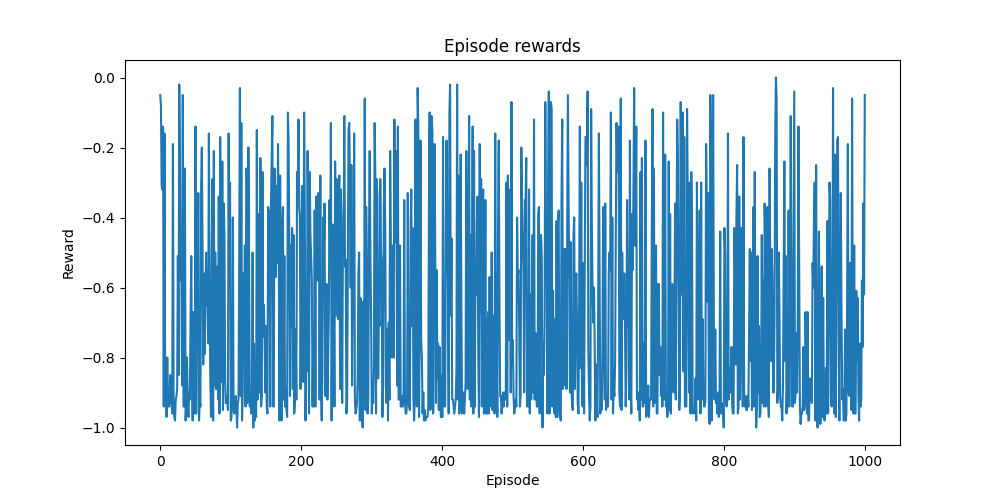

In [8]:
optimal = np.argmax(qmatrix, axis=1)
print('Optimal policy: ', optimal)

plt.figure(figsize=(10, 5))
plt.plot(ep_rewards)
plt.title("Episode rewards")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.show()

In [9]:
env = gym.wrappers.RecordVideo(env=env, video_folder=os.path.join(cwd,"video","3-1b"), name_prefix="test-video")
# Simulate one episode with the learned policy

s = env.reset()[0]
for step in range(env.spec.max_episode_steps):
        
    best_act = jnp.argmax(q_value_nn(params, s))
    # Update Env
    s, r, done, truncated, info = env.step(int(best_act))

    env.render()
    if done:
        break

In [ ]:
print("Final Parameters:", params)

Final Parameters: {'linear': {'w': Array([[-7.4181850e-03,  2.8496585e-03,  2.3603009e-03, -7.3943180e-03],
       [ 2.6115065e-03,  6.6128268e-05,  2.3957365e-03, -7.5109759e-03],
       [ 2.5794304e-03,  3.1713754e-04,  4.8995781e-04, -3.8401808e-03],
       [ 1.2116713e-03,  8.5930398e-04, -9.3529606e-04, -1.5291221e-03],
       [-7.2089764e-03,  2.5496306e-03,  6.5289656e-05,  3.1067214e-03],
       [ 7.2553041e-05,  7.2553041e-05,  7.2553041e-05,  7.2553041e-05],
       [ 3.6451227e-05,  2.0963040e-05,  2.0963040e-05,  1.3588343e-04],
       [ 4.8335845e-05,  4.8335845e-05,  4.8335845e-05,  4.8335845e-05],
       [-7.4507007e-03,  1.4182918e-07,  2.3319819e-03,  2.8327578e-03],
       [ 2.5739458e-03,  1.8127514e-04,  8.5957894e-05,  1.5082334e-05],
       [ 8.0520951e-04,  1.7791836e-09,  1.7791836e-09,  1.4806176e-05],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 1.5758773e-07,  1.5758773e-07,  1.5758773e-07,  1.5758773e-07],
       [ 7.04665

: 

It doesn't converge to optimal.